In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data=pd.read_csv(r"C:\Users\Home\AppData\Local\Programs\Python\Python312\Scripts/data.csv",header='infer')
data.info()
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

=== INITIAL DATA SHAPE & INFO ===
(11914, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914

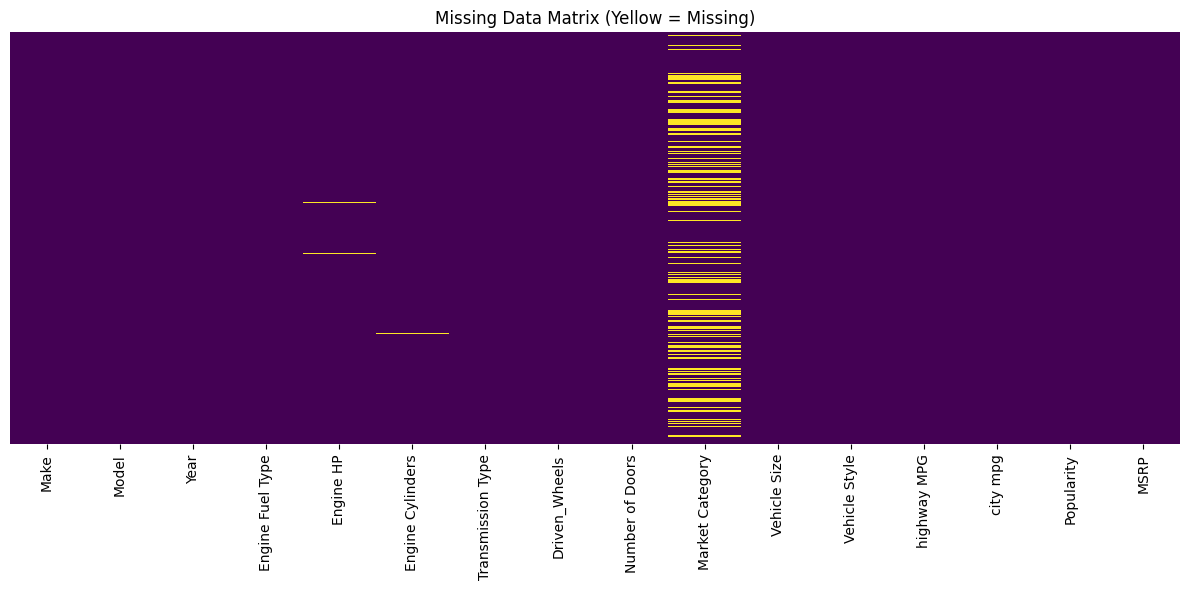


=== ANALYZING PATTERN FOR 'Market Category' ===
Average MSRP for rows where 'Market Category' is:
  - Missing: $19961.40
  - Not Missing: $50042.85
T-test for difference in MSRP: p-value = 0.0000
-> The difference is statistically significant (p < 0.05). Data is likely MAR/MNAR.

=== PERFORMING ADVANCED IMPUTATION ===
Imputing numerical columns with MICE...
Imputing categorical columns with 'Missing' category...

=== FINAL DATA CHECK ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  float64
 3   Engine Fuel Type   11914 non-null  object 
 4   Engine HP          11914 non-null  float64
 5   Engine Cylinders   11914 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Whee

In [2]:
# --- ADVANCED MISSING DATA ANALYSIS & IMPUTATION ---
print("=== INITIAL DATA SHAPE & INFO ===")
print(data.shape)
data.info()

# 1. Calculate and Visualize the Missing Data Matrix
print("\n=== MISSING VALUE ANALYSIS ===")

# Calculate total missing values per column
missing_count = data.isnull().sum()
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Create a summary DataFrame
missing_summary = pd.DataFrame({
    'Missing_Count': missing_count,
    'Missing_Percentage': missing_percentage
})
# Only show columns that actually have missing values
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0]
print("Summary of Columns with Missing Values:")
print(missing_summary.sort_values('Missing_Percentage', ascending=False))

# Visualize the missingness matrix
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data Matrix (Yellow = Missing)')
plt.tight_layout()
plt.show()

# 2. Analyze Patterns of Missingness
# Example: Check if missingness in 'Market Category' is related to the target variable 'MSRP'
if 'Market Category' in data.columns and data['Market Category'].isnull().sum() > 0 and 'MSRP' in data.columns:
    print("\n=== ANALYZING PATTERN FOR 'Market Category' ===")
    # Create a flag for missingness
    data['MC_Missing'] = data['Market Category'].isnull()

    # Compare the mean of MSRP between the two groups
    group_means = data.groupby('MC_Missing')['MSRP'].mean()
    print("Average MSRP for rows where 'Market Category' is:")
    print(f"  - Missing: ${group_means.get(True, 0):.2f}")
    print(f"  - Not Missing: ${group_means.get(False, 0):.2f}")
    
    # Perform a t-test to check if the difference is statistically significant
    from scipy.stats import ttest_ind
    group_missing = data[data['MC_Missing'] == True]['MSRP']
    group_not_missing = data[data['MC_Missing'] == False]['MSRP']
    
    # Handle groups that might be too small for a t-test
    if len(group_missing) > 1 and len(group_not_missing) > 1:
        t_stat, p_value = ttest_ind(group_missing, group_not_missing, nan_policy='omit', equal_var=False)
        print(f"T-test for difference in MSRP: p-value = {p_value:.4f}")
        if p_value < 0.05:
            print("-> The difference is statistically significant (p < 0.05). Data is likely MAR/MNAR.")
        else:
            print("-> The difference is not statistically significant. Data could be MCAR.")
    else:
        print("Insufficient data for statistical test.")
    
    # Drop the temporary column after analysis
    data = data.drop('MC_Missing', axis=1)

# 3. Implement Advanced Imputation Strategy
print("\n=== PERFORMING ADVANCED IMPUTATION ===")

# Strategy: Use MICE for numerical columns, 'Missing' category for categorical
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# A. Impute Numerical columns with MICE
print("Imputing numerical columns with MICE...")
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()

# Create and fit the MICE imputer
mice_imputer = IterativeImputer(random_state=42, max_iter=10, sample_posterior=True)
data[numeric_columns] = mice_imputer.fit_transform(data[numeric_columns])

# B. Impute Categorical columns with 'Missing' category
print("Imputing categorical columns with 'Missing' category...")
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if data[col].isnull().sum() > 0:
        data[col].fillna('Missing', inplace=True)

# Verify no missing values remain
print("\n=== FINAL DATA CHECK ===")
print(data.info())
print("Missing values after advanced imputation:", data.isnull().sum().sum())

In [3]:
def calculate_statistics(dataset):
    
    df = pd.read_csv(r"C:\Users\Home\AppData\Local\Programs\Python\Python312\Scripts/data.csv",header='infer')

    numeric_columns = df.select_dtypes(include=[np.number])

    statistics = {}

    for column in numeric_columns.columns:
        stats_dict = {}

        stats_dict['count'] = numeric_columns[column].count()

        stats_dict['sum'] = numeric_columns[column].sum()

        stats_dict['range'] = numeric_columns[column].max() - numeric_columns[column].min()

        stats_dict['min'] = numeric_columns[column].min()

        stats_dict['max'] = numeric_columns[column].max()

        stats_dict['mean'] = numeric_columns[column].mean()

        stats_dict['median'] = numeric_columns[column].median()

        mode_counts = numeric_columns[column].value_counts()
        stats_dict['mode'] = mode_counts.idxmax()

        stats_dict['variance'] = numeric_columns[column].var()

        stats_dict['std_dev'] = numeric_columns[column].std()

        statistics[column] = stats_dict

    return statistics

result = calculate_statistics(data)
for column, stats_dict in result.items():
    print(f"Column: {column}")
    for stat, value in stats_dict.items():
        print(f"{stat}: {value}")
    print("\n")


Column: Year
count: 11914
sum: 23951719
range: 27
min: 1990
max: 2017
mean: 2010.384337753903
median: 2015.0
mode: 2015
variance: 57.45245676360936
std_dev: 7.579739887595705


Column: Engine HP
count: 11845
sum: 2953978.0
range: 946.0
min: 55.0
max: 1001.0
mean: 249.38607007176023
median: 227.0
mode: 200.0
variance: 11922.864530695864
std_dev: 109.19187025917206


Column: Engine Cylinders
count: 11884
sum: 66893.0
range: 16.0
min: 0.0
max: 16.0
mean: 5.628828677213059
median: 6.0
mode: 4.0
variance: 3.170391592627014
std_dev: 1.780559348246223


Column: Number of Doors
count: 11908
sum: 40917.0
range: 2.0
min: 2.0
max: 4.0
mean: 3.4360933825999327
median: 4.0
mode: 4.0
variance: 0.7767168106289198
std_dev: 0.8813153865835543


Column: highway MPG
count: 11914
sum: 317359
range: 342
min: 12
max: 354
mean: 26.637485311398354
median: 26.0
mode: 24
variance: 78.552782595478
std_dev: 8.863000766979432


Column: city mpg
count: 11914
sum: 235102
range: 130
min: 7
max: 137
mean: 19.733254994

In [ ]:
def display_unique_values(dataset):
    
    df = pd.read_csv(r"C:\Users\Home\AppData\Local\Programs\Python\Python312\Scripts/data.csv",header='infer')

    # Display unique value counts and unique values for each column
    for column in df.columns:
        unique_values = df[column].unique()
        unique_value_counts = df[column].value_counts()

        print(f"Column: {column}")
        print("Unique Values:")
        print(unique_values)
        print("\nUnique Value Counts:")
        print(unique_value_counts)
        print("\n")



display_unique_values(data)


Column: Make
Unique Values:
['BMW' 'Audi' 'FIAT' 'Mercedes-Benz' 'Chrysler' 'Nissan' 'Volvo' 'Mazda'
 'Mitsubishi' 'Ferrari' 'Alfa Romeo' 'Toyota' 'McLaren' 'Maybach'
 'Pontiac' 'Porsche' 'Saab' 'GMC' 'Hyundai' 'Plymouth' 'Honda'
 'Oldsmobile' 'Suzuki' 'Ford' 'Cadillac' 'Kia' 'Bentley' 'Chevrolet'
 'Dodge' 'Lamborghini' 'Lincoln' 'Subaru' 'Volkswagen' 'Spyker' 'Buick'
 'Acura' 'Rolls-Royce' 'Maserati' 'Lexus' 'Aston Martin' 'Land Rover'
 'Lotus' 'Infiniti' 'Scion' 'Genesis' 'HUMMER' 'Tesla' 'Bugatti']

Unique Value Counts:
Make
Chevrolet        1123
Ford              881
Volkswagen        809
Toyota            746
Dodge             626
Nissan            558
GMC               515
Honda             449
Mazda             423
Cadillac          397
Mercedes-Benz     353
Suzuki            351
BMW               334
Infiniti          330
Audi              328
Hyundai           303
Volvo             281
Subaru            256
Acura             252
Kia               231
Mitsubishi        213
Lexu

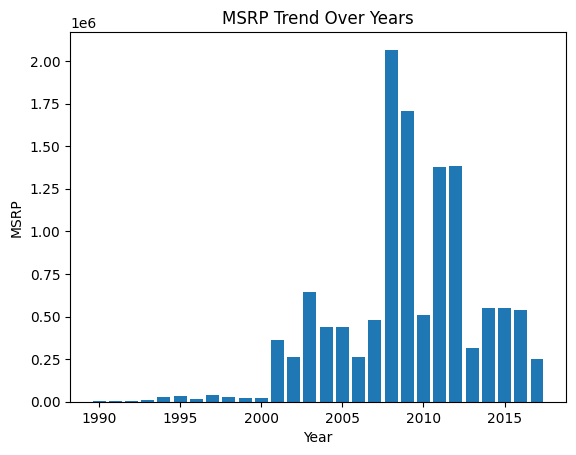

In [5]:
import matplotlib.pyplot as plt

years = data['Year']
msrp = data['MSRP']

plt.bar(years, msrp)
plt.xlabel('Year')
plt.ylabel('MSRP')
plt.title('MSRP Trend Over Years')
plt.show()

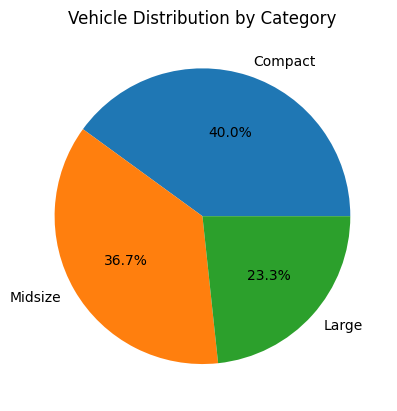

In [4]:
# Data
categories = ['Compact', 'Midsize', 'Large']
counts = [4763, 4373, 2777]

# Create pie chart
plt.pie(counts, labels=categories, autopct='%1.1f%%')
plt.title('Vehicle Distribution by Category')
plt.show()

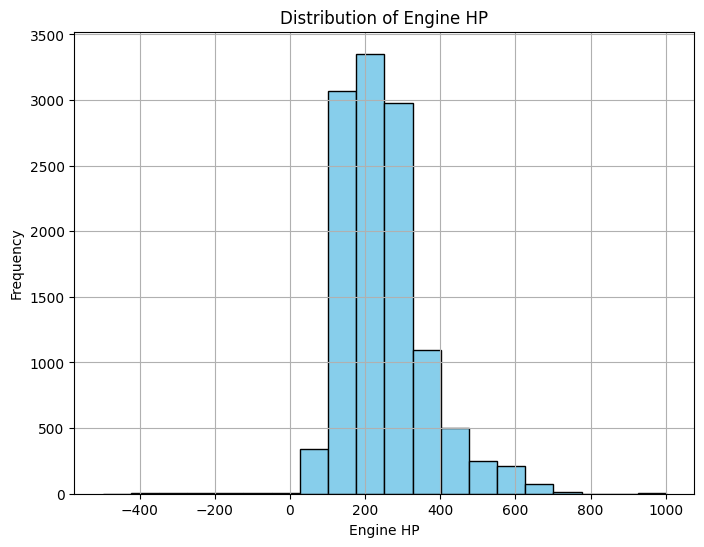

In [5]:
import pandas as pd
import matplotlib.pyplot as plt



# Choose the variable for which you want to create a histogram
variable = 'Engine HP'

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(data[variable], bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel(variable)
plt.ylabel('Frequency')
plt.title(f'Distribution of {variable}')
plt.grid(True)
plt.show()




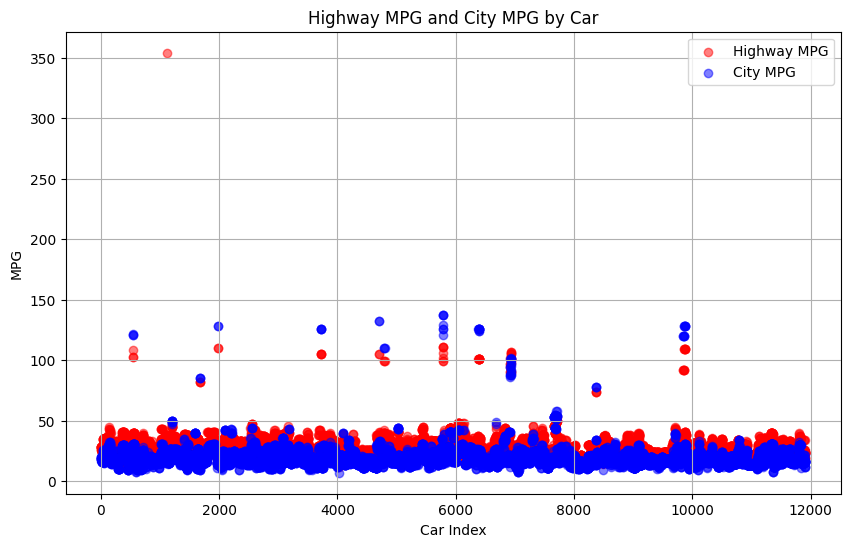

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' contains columns: 'Make', 'highway MPG', and 'city mpg'


# Plot the scatter plot for 'Highway MPG'
plt.figure(figsize=(10, 6))  # Adjust figure size if necessary
plt.scatter(data.index, data['highway MPG'], color='red', alpha=0.5, label='Highway MPG')

# Plot the scatter plot for 'City MPG'
plt.scatter(data.index, data['city mpg'], color='blue', alpha=0.5, label='City MPG')

plt.xlabel('Car Index')
plt.ylabel('MPG')
plt.title('Highway MPG and City MPG by Car')
plt.legend()
plt.grid(True)
plt.show()

Accuracy:  0.7981535879143936
Classification Report:
               precision    recall  f1-score   support

     Compact       0.83      0.84      0.84       953
       Large       0.81      0.81      0.81       555
     Midsize       0.75      0.74      0.75       875

    accuracy                           0.80      2383
   macro avg       0.80      0.80      0.80      2383
weighted avg       0.80      0.80      0.80      2383



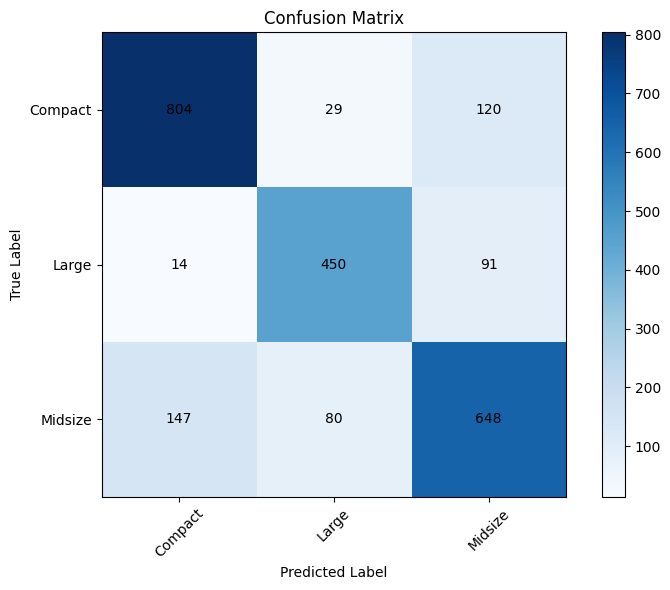

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Selecting features and target
X = data[['Engine HP', 'Engine Cylinders', 'Number of Doors']]
y = data['Vehicle Size']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Taking input for the number of nearest neighbors
k = int(input("Enter the number of nearest neighbors: "))

# Initialize the KNN classifier
model = KNeighborsClassifier(n_neighbors=k, weights='distance')

# Train the model
model.fit(X_train, y_train)

# Predictions
pred = model.predict(X_test)

# Accuracy calculation
acc = accuracy_score(y_test, pred)
print("Accuracy: ", acc)

# Classification report
report = classification_report(y_test, pred)
print("Classification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(y_test, pred)

# Display confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(np.unique(y))), np.unique(y), rotation=45)
plt.yticks(np.arange(len(np.unique(y))), np.unique(y))
for i in range(len(np.unique(y))):
    for j in range(len(np.unique(y))):
        plt.text(j, i, cm[i, j], horizontalalignment='center', verticalalignment='center', color='black')
plt.tight_layout()
plt.show()


Enter the value of k(nearest neighbors):-  3


MAE:-  4786.9408916144375
MSE:-  658087177.9626073
RMSE:-  25653.209895890363
MAPE:- 11.676634219349511


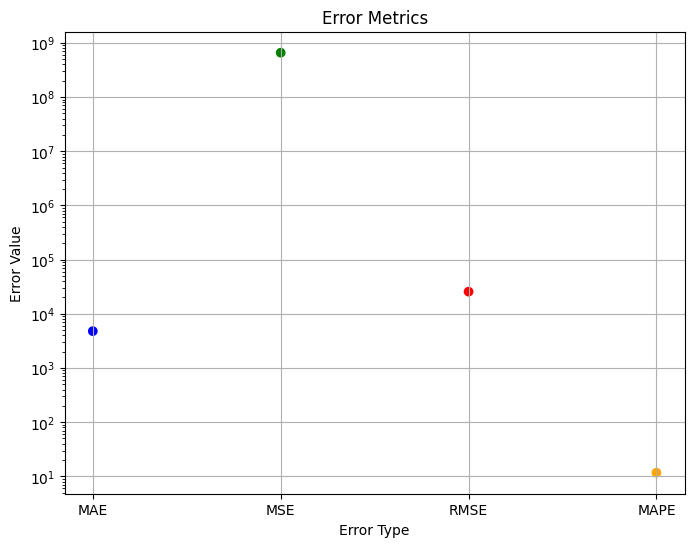

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
k=int(input("Enter the value of k(nearest neighbors):- "))
x = data[['Year', 'Engine HP', 'Engine Cylinders', 'highway MPG', 'city mpg', 'Popularity']]
y = data['MSRP']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
model=KNeighborsRegressor(n_neighbors=k,weights='distance')
model.fit(x_train,y_train)
pred=model.predict(x_test)
mae=mean_absolute_error(y_test,pred)
mse=mean_squared_error(y_test,pred)
rmse=np.sqrt(mse)
mape = np.mean(np.abs((y_test - pred) / y_test)) * 100
print("MAE:- ",mae)
print("MSE:- ",mse)
print("RMSE:- ",rmse)
print('MAPE:-',mape)

# Error values
errors = [mae, mse, rmse, mape]
error_labels = ['MAE', 'MSE', 'RMSE', 'MAPE']

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(error_labels, errors, color=['blue', 'green', 'red', 'orange'])
plt.xlabel('Error Type')
plt.ylabel('Error Value')
plt.title('Error Metrics')
plt.yscale('log')  # Setting y-axis scale to logarithmic
plt.grid()
plt.show()